# Set up packages and server

In [58]:
# specify the GPU
import os
os.environ['TORCH_HOME'] = 'your/own/cache/directory'
os.environ['CUDA_VISIBLE_DEVICES'] = '2'

In [96]:
# Data visualization
import plotly.express as px
from ipywidgets import interact

# Data processing
import pandas as pd
import numpy as np
import geopandas as gpd

# Model training
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import copy
from torch.optim import Adam
from torch.nn import CrossEntropyLoss
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau

import timm
from sklearn.model_selection import GroupShuffleSplit
# import lightning as L
# from lightning import Trainer
# from lightning.pytorch.callbacks import EarlyStopping, ModelCheckpoint

# Others
import os
import sys
import gc
from pathlib import Path
import os.path


from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, matthews_corrcoef, cohen_kappa_score
import matplotlib.pyplot as plt
import seaborn as sns
import random


from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image

# project lib
PROJECT_SRC_PATH = os.path.join( '/workspace/workspace/ufo-prediction', 'src-RCA-UFO')
sys.path.append(PROJECT_SRC_PATH)
import dataset

In [60]:
torch.cuda.empty_cache()

In [61]:
# Check is GPU is enabled
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device: {}".format(device))

# Get specific GPU model
if str(device) == "cuda:0":
  print("GPU: {}".format(torch.cuda.get_device_name(0)))

Device: cuda:0
GPU: NVIDIA A100-PCIE-40GB


# 2. Load and preprocess the training and validation data

In [115]:
def extract_building_id(filepath):
    """
    Extracts the building ID from the given filepath string.
    Knowing that the building ID always contains an underscore and considering the filename
    format '[age_right]_[building_id]_[subscript].jpg', this function returns the 'building_id'.
    """
    # Isolate the filename from the filepath
    filename = filepath.split('/')[-1]
    # Split the filename at underscores
    parts = filename.split('_')
    # Considering the first part is age_right and the last part is the subscript with .jpg,
    # the building ID is everything in between.
    # Rejoin the middle parts to account for underscores within the building ID itself.
    building_id = '_'.join(parts[1:-1])
    return building_id

def get_age_bracket(age):
    if 1900 <= age <= 1924:
        return '1900-1924'
    elif 1925 <= age <= 1945:
        return '1925-1945'
    elif 1946 <= age <= 1959:
        return '1946-1959'
    elif 1960 <= age <= 1969:
        return '1960-1969'
    elif 1970 <= age <= 1984:
        return '1970-1984'
    elif 1985 <= age <= 1999:
        return '1985-1999'
    elif 2000 <= age <= 2050:
        return '2000-2050'
    else:
        return 'Unknown'  # For ages outside the specified brackets or if age couldn't be determined
    
def extract_age_and_name(filepath):
    filename = os.path.basename(filepath)  # Get the filename from the filepath
    age_and_name = filename.split('.')[0]  # Split by dot and take the first part
    age = ''.join(filter(str.isdigit, age_and_name))[:4]  # Extract first 4 digits for age
    if age:  # Ensure age string is not empty
        age = int(age)
        age_bracket = get_age_bracket(age)  # Get the age bracket
    else:  # Default age if no digits found
        age_bracket = 'Unknown'
    return age_bracket


age_bracket_to_int = {
    '1900-1924': 0,
    '1925-1945': 1,
    '1946-1959': 2,
    '1960-1969': 3,
    '1970-1984': 4,
    '1985-1999': 5,
    '2000-2050': 6
}

In [116]:
directories = [
    #Path('/workspace/workspace/ufo-prediction/image_data_NLD'),
    #Path('/workspace/workspace/ufo-prediction/image_data_ESP'),  # Add your second directory path here
    #Path('/workspace/workspace/ufo-prediction/image_data_FRA'),
    Path('/workspace/workspace/ufo-prediction/image_data_NLD_adv'),
    Path('/workspace/workspace/ufo-prediction/image_data_ESP_adv'),  # Add your second directory path here
    Path('/workspace/workspace/ufo-prediction/image_data_FRA_adv')
   # Add your third directory path here
]

filepaths = pd.Series(
    [item for directory in directories for item in directory.glob('**/*.jpg')],
    name='Filepath'
).astype(str)

age_brackets = pd.Series(filepaths.apply(lambda x: extract_age_and_name(x)), name='Age Brackets')
building_ids = pd.Series(filepaths.apply(extract_building_id), name='Building ID')

# Filter to exclude 'Unknown' age brackets and corresponding filepaths and building IDs
filtered_indices = age_brackets != 'Unknown'
filtered_age_brackets = age_brackets[filtered_indices]
filtered_filepaths = filepaths[filtered_indices]
filtered_building_ids = building_ids[filtered_indices]

# Create DataFrame
trainval_df = pd.concat([filtered_filepaths, filtered_age_brackets, filtered_building_ids], axis=1)
trainval_df = trainval_df.sample(frac=1.0, random_state=1).reset_index(drop=True)
trainval_df['Target'] = trainval_df['Age Brackets'].map(age_bracket_to_int)

print(trainval_df.head())

                                            Filepath Age Brackets  \
0  /workspace/workspace/ufo-prediction/image_data...    1985-1999   
1  /workspace/workspace/ufo-prediction/image_data...    2000-2050   
2  /workspace/workspace/ufo-prediction/image_data...    1925-1945   
3  /workspace/workspace/ufo-prediction/image_data...    1970-1984   
4  /workspace/workspace/ufo-prediction/image_data...    2000-2050   

                 Building ID  Target  
0  v0.1-FRA.9.1.2.10_1-16248       5  
1      v0.1-NLD.10.20_1-5990       6  
2      v0.1-NLD.7.44_1-21630       1  
3      v0.1-NLD.14.69_1-3867       4  
4      v0.1-NLD.10.9_1-30368       6  


In [117]:
len(trainval_df)

34073

In [118]:
# Initialize the GroupShuffleSplit
gss = GroupShuffleSplit(n_splits=1, train_size=0.6, random_state=1)

# Split the DataFrame into training and validation+test sets
# We use 'Building ID' as the groups to keep images of the same building together
train_idx, valtest_idx = next(gss.split(trainval_df, groups=trainval_df['Building ID']))
train_df = trainval_df.iloc[train_idx]
valtest_df = trainval_df.iloc[valtest_idx]

# Now split the validation+test set into validation and test sets
gss_val_test = GroupShuffleSplit(n_splits=1, train_size=0.7, random_state=1)
val_idx, test_idx = next(gss_val_test.split(valtest_df, groups=valtest_df['Building ID']))
val_df = valtest_df.iloc[val_idx]
test_df = valtest_df.iloc[test_idx]

# Check the sizes of each set and sample outputs
print("Training set size:", train_df.shape)
print("Validation set size:", val_df.shape)
print("Testing set size:", test_df.shape)
print("\nSample training data:", train_df.head())
print("\nSample validation data:", val_df.head())
print("\nSample testing data:", test_df.head())


Training set size: (20813, 4)
Validation set size: (9252, 4)
Testing set size: (4008, 4)

Sample training data:                                             Filepath Age Brackets  \
1  /workspace/workspace/ufo-prediction/image_data...    2000-2050   
2  /workspace/workspace/ufo-prediction/image_data...    1925-1945   
3  /workspace/workspace/ufo-prediction/image_data...    1970-1984   
4  /workspace/workspace/ufo-prediction/image_data...    2000-2050   
5  /workspace/workspace/ufo-prediction/image_data...    1970-1984   

             Building ID  Target  
1  v0.1-NLD.10.20_1-5990       6  
2  v0.1-NLD.7.44_1-21630       1  
3  v0.1-NLD.14.69_1-3867       4  
4  v0.1-NLD.10.9_1-30368       6  
5  v0.1-NLD.7.16_1-17566       4  

Sample validation data:                                              Filepath Age Brackets  \
8   /workspace/workspace/ufo-prediction/image_data...    1970-1984   
9   /workspace/workspace/ufo-prediction/image_data...    1985-1999   
10  /workspace/workspace/ufo

In [119]:
def check_building_id_exclusivity(train_df, val_df, test_df):
    # Extract building IDs from each dataset into sets
    train_ids = set(train_df['Building ID'])
    val_ids = set(val_df['Building ID'])
    test_ids = set(test_df['Building ID'])

    # Check for intersections between the sets
    train_val_intersection = train_ids.intersection(val_ids)
    train_test_intersection = train_ids.intersection(test_ids)
    val_test_intersection = val_ids.intersection(test_ids)

    # Report the results
    if not train_val_intersection and not train_test_intersection and not val_test_intersection:
        print("Check passed: No building ID appears in more than one dataset.")
    else:
        if train_val_intersection:
            print("Overlap found between training and validation datasets:", train_val_intersection)
        if train_test_intersection:
            print("Overlap found between training and testing datasets:", train_test_intersection)
        if val_test_intersection:
            print("Overlap found between validation and testing datasets:", val_test_intersection)

# Example usage:
check_building_id_exclusivity(train_df, val_df, test_df)


Check passed: No building ID appears in more than one dataset.


In [120]:
class AgeBracketDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path = self.dataframe.iloc[idx, 0]
        image = Image.open(img_path).convert("RGB")
        label = int(self.dataframe.iloc[idx, -1])  # Assuming the label/target is in the third column

        if self.transform:
            image = self.transform(image)

        return image, label


In [121]:
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224),  # ResNet-18 expects 224x224 inputs
    transforms.RandomHorizontalFlip(),  # A common form of augmentation
    #transforms.RandomRotation(15),  # Rotates the image by up to 15 degrees
    #transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),  # Randomly jitters color
    #transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Normalization
])

val_test_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_dataset = AgeBracketDataset(train_df, transform=train_transforms)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

val_dataset = AgeBracketDataset(val_df, transform=val_test_transforms)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True)

test_dataset = AgeBracketDataset(test_df, transform=val_test_transforms)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

# 3. Train model

In [122]:
def train_and_evaluate_val_loss(model, train_loader, val_loader, optimizer, criterion, scheduler, num_epochs=50, patience=7):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    best_val_loss = float('inf')  # Initialize the best validation loss as infinity
    best_model_wts = copy.deepcopy(model.state_dict())
    epochs_no_improve = 0
    early_stop = False

    for epoch in range(num_epochs):
        model.train()  # Set model to training mode
        running_loss = 0.0

        # Training phase
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        # Validation phase
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

        avg_val_loss = val_loss / len(val_loader)

        print(f'Epoch {epoch+1}/{num_epochs}, Training Loss: {running_loss / len(train_loader):.4f}, Validation Loss: {avg_val_loss:.4f}')
        
        scheduler.step(avg_val_loss)  # Learning rate scheduler step based on validation loss

        # Check for improvement based on validation loss
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1

        # Early stopping check
        if epochs_no_improve >= patience:
            print(f'Early stopping triggered after {epoch + 1} epochs.')
            early_stop = True
            break
    
    if not early_stop:
        print('Reached maximum epoch limit.')

    # Load best model weights based on lowest validation loss
    model.load_state_dict(best_model_wts)
    return best_val_loss  # Return the best validation loss achieved


In [123]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Best Parameters
batch_size = 32
learning_rate = 0.0005

# Initialize the model
model = models.resnet18(pretrained=True)

# Freeze all layers first
for param in model.parameters():
    param.requires_grad = False

# Replace the last fully connected layer to adapt to the number of classes (7 in this case)
num_classes = 7
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, num_classes)

# Unfreeze the final layer so it can learn during training
for param in model.layer4.parameters():
    param.requires_grad = True
for param in model.fc.parameters():
    param.requires_grad = True


model = model.to(device)
print(model)

# Setup DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Setup optimizer, criterion, and scheduler
optimizer = Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=learning_rate)
criterion = nn.CrossEntropyLoss()
scheduler = ReduceLROnPlateau(optimizer, 'min', factor=0.1, patience=5, verbose=True)

# Train the model
best_val_loss = train_and_evaluate_val_loss(model, train_loader, val_loader, optimizer, criterion, scheduler, num_epochs=50, patience=7)

print("Best Validation Loss:", best_val_loss)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

## 4. Prepare the Test DataLoader

          Metric  Actual Model  Random Model
0       Accuracy        0.2592        0.1642
1      Precision        0.2895        0.1635
2         Recall        0.2592        0.1642
3       F1-Score        0.2417        0.1637
4            MCC        0.1442        0.0136
5  Cohen's Kappa        0.1353        0.0136


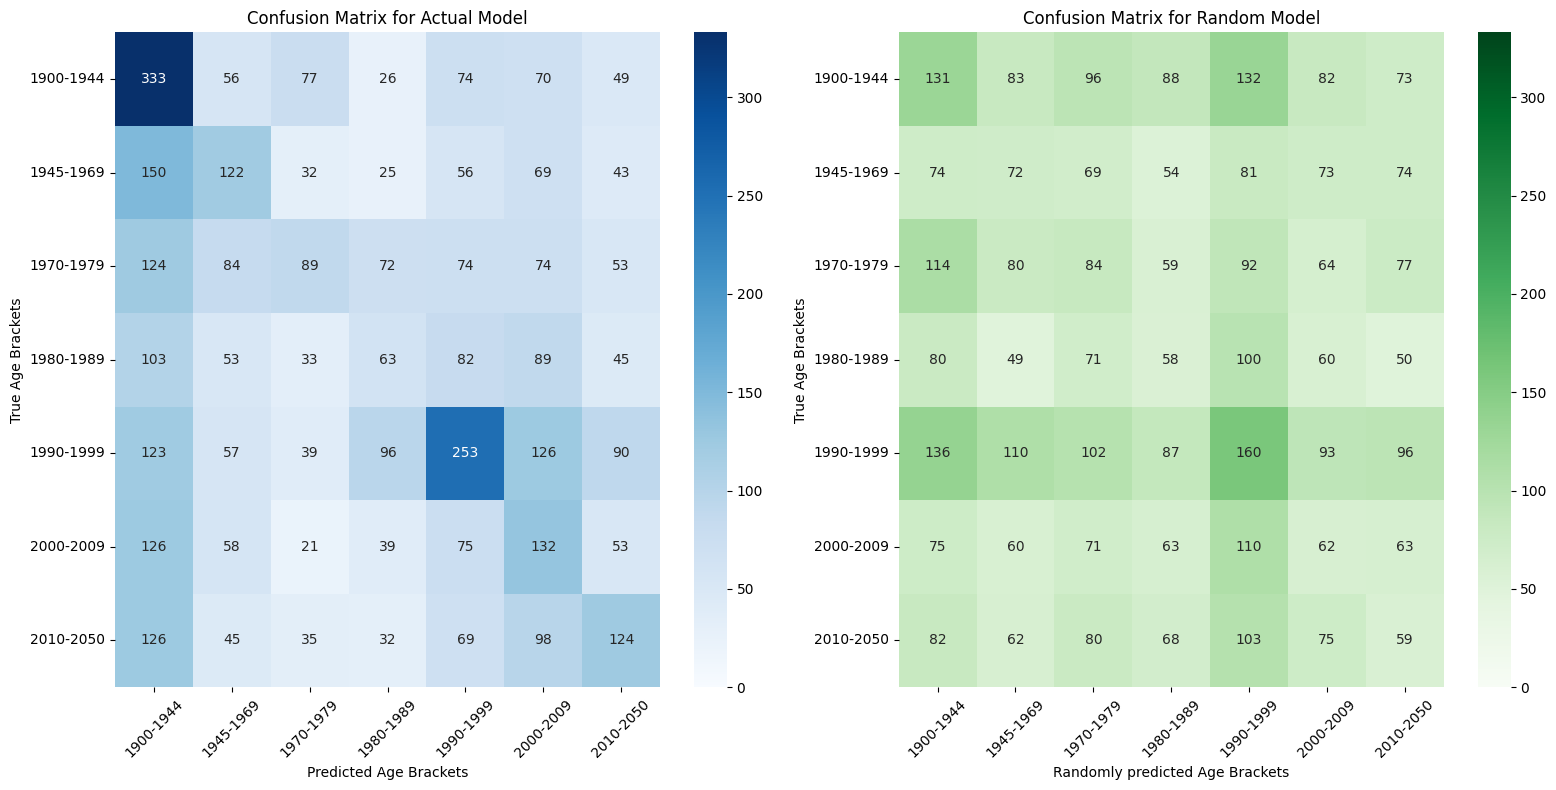

In [124]:
# Evaluate the actual model
model.eval()
true_classes = []
predicted_classes = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        true_classes.extend(labels.cpu().numpy())
        predicted_classes.extend(predicted.cpu().numpy())

true_classes = np.array(true_classes)
predicted_classes = np.array(predicted_classes)

# Generate random predictions
random_predictions = np.random.choice(np.unique(true_classes), size=len(true_classes), p=np.bincount(true_classes)/len(true_classes))

# Compute metrics for the actual model
accuracy = accuracy_score(true_classes, predicted_classes)
precision, recall, f1, _ = precision_recall_fscore_support(true_classes, predicted_classes, average='weighted')
mcc = matthews_corrcoef(true_classes, predicted_classes)
cohen_kappa = cohen_kappa_score(true_classes, predicted_classes)

# Compute metrics for the random model
rand_accuracy = accuracy_score(true_classes, random_predictions)
rand_precision, rand_recall, rand_f1, _ = precision_recall_fscore_support(true_classes, random_predictions, average='weighted')
rand_mcc = matthews_corrcoef(true_classes, random_predictions)
rand_cohen_kappa = cohen_kappa_score(true_classes, random_predictions)

# Create a DataFrame to hold the metrics for easier comparison
metrics_df = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'MCC', 'Cohen\'s Kappa'],
    'Actual Model': [np.round(accuracy, 4), np.round(precision, 4), np.round(recall, 4), np.round(f1, 4), np.round(mcc, 4), np.round(cohen_kappa, 4)],
    'Random Model': [np.round(rand_accuracy, 4), np.round(rand_precision, 4), np.round(rand_recall, 4), np.round(rand_f1, 4), np.round(rand_mcc, 4), np.round(rand_cohen_kappa, 4)]
})

# Display the DataFrame
print(metrics_df)

# Determine the maximum value for normalization of the heatmap colors
vmax = max(np.max(cm), np.max(rand_cm))

# Plot the confusion matrices side by side
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))

# Confusion Matrix for Actual Model
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0], vmin=0, vmax=vmax,
            xticklabels=['1900-1944', '1945-1969', '1970-1979', '1980-1989', '1990-1999', '2000-2009', '2010-2050'],
            yticklabels=['1900-1944', '1945-1969', '1970-1979', '1980-1989', '1990-1999', '2000-2009', '2010-2050'])
axes[0].set_title('Confusion Matrix for Actual Model')
axes[0].set_xlabel('Predicted Age Brackets')
axes[0].set_ylabel('True Age Brackets')
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45)
axes[0].set_yticklabels(axes[0].get_yticklabels(), rotation=0)

# Confusion Matrix for Random Model
sns.heatmap(rand_cm, annot=True, fmt='d', cmap='Greens', ax=axes[1], vmin=0, vmax=vmax,
            xticklabels=['1900-1944', '1945-1969', '1970-1979', '1980-1989', '1990-1999', '2000-2009', '2010-2050'],
            yticklabels=['1900-1944', '1945-1969', '1970-1979', '1980-1989', '1990-1999', '2000-2009', '2010-2050'])
axes[1].set_title('Confusion Matrix for Random Model')
axes[1].set_xlabel('Randomly predicted Age Brackets')
axes[1].set_ylabel('True Age Brackets')
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45)
axes[1].set_yticklabels(axes[1].get_yticklabels(), rotation=0)

plt.tight_layout()  # Adjust layout to not overlap
plt.show()


In [125]:
class CustomDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path = self.dataframe.iloc[idx, 0]
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, img_path

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Assuming test_df is your DataFrame
test_dataset = CustomDataset(dataframe=test_df, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


# 5. Infer age brackets

In [144]:
model.eval()  # Set the model to evaluation mode
probabilities_list = []
file_paths = []
predictions = []

with torch.no_grad():
    for inputs, paths in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        probabilities = F.softmax(outputs, dim=1)  # Apply softmax to convert logits to probabilities
        _, predicted = torch.max(outputs, 1)
        predictions.extend(predicted.cpu().numpy())
        probabilities_list.extend(probabilities.cpu().numpy())  # Store probabilities
        file_paths.extend(paths)

# Assuming there are 6 classes, adjust the labels if different
class_labels = [f'Class_{i}' for i in range(probabilities.shape[1])]  # Adjust based on the softmax output size
predictions_df = pd.DataFrame(probabilities_list, columns=class_labels)
predictions_df['Predicted Class'] = predictions
predictions_df['FilePath'] = file_paths  # Add the file paths as a column in the DataFrame
# Extract building IDs and add them as a new column
predictions_df['id'] = predictions_df['FilePath'].apply(extract_building_id)

print(predictions_df.head())  # Display the first few rows of the DataFrame to check the output


    Class_0   Class_1   Class_2   Class_3   Class_4   Class_5   Class_6  \
0  0.168815  0.110495  0.202844  0.126808  0.097622  0.160515  0.132902   
1  0.318306  0.136656  0.297691  0.072343  0.046578  0.068936  0.059489   
2  0.424934  0.129380  0.125310  0.036584  0.058254  0.125413  0.100125   
3  0.186083  0.175121  0.204827  0.071955  0.062908  0.133701  0.165405   
4  0.059640  0.100415  0.115762  0.261843  0.394259  0.025300  0.042782   

   Predicted Class                                           FilePath  \
0                2  /workspace/workspace/ufo-prediction/image_data...   
1                0  /workspace/workspace/ufo-prediction/image_data...   
2                0  /workspace/workspace/ufo-prediction/image_data...   
3                2  /workspace/workspace/ufo-prediction/image_data...   
4                4  /workspace/workspace/ufo-prediction/image_data...   

                          id  
0  v0.1-FRA.9.1.2.10_1-16248  
1  v0.1-FRA.13.6.2.10_1-7013  
2   v0.1-FRA.6.7.

In [104]:
# THIS GIVES YOU ONE OUTPUT LABEL
# model.eval()  # Set model to evaluation mode
# predictions = []
# file_paths = []

# with torch.no_grad():
#     for inputs, paths in test_loader:
#         inputs = inputs.to(device)
#         outputs = model(inputs)
#         _, predicted = torch.max(outputs, 1)
#         predictions.extend(predicted.cpu().numpy())
#         file_paths.extend(paths)


# 6. Concatenate Building ID and use to merge to rca-ufo dataset

In [145]:
unique_ids = predictions_df['id'].unique()
print(len(unique_ids))
print(len(predictions_df))


1775
4008


In [160]:
# Calculate the sum of the probabilities for each class across all images for each building
sum_probs = predictions_df.groupby('id')[['Class_0', 'Class_1', 'Class_2', 'Class_3', 'Class_4', 'Class_5', 'Class_6']].sum()

# Normalize these sums so that the sum across all classes for each building equals 1
sum_probs_normalized = sum_probs.div(sum_probs.sum(axis=1), axis=0)

# Determine the predicted class for each building based on maximum confidence
# First, find the maximum probability for each class per building
max_conf_probs = predictions_df.groupby('id')[['Class_0', 'Class_1', 'Class_2', 'Class_3', 'Class_4', 'Class_5', 'Class_6']].max()

# Predicted class is the one with the highest maximum probability
max_conf_probs['Predicted Class'] = max_conf_probs.idxmax(axis=1).str.extract('(\d+)').astype(int)

# Now, get the first file path for each building as a representative path
# This assumes that the 'FilePath' was a column in predictions_df; if not, this line will fail
representative_file_paths = predictions_df.groupby('id')['FilePath'].first()

sum_probs_normalized.reset_index(inplace=True)
max_conf_probs.reset_index(inplace=True)


# Create the final DataFrame to have the normalized sums and the maximum confidence predicted class
final_results = pd.merge(sum_probs_normalized, max_conf_probs[['id', 'Predicted Class']], on='id', how='left')

print(final_results)


                            id   Class_0   Class_1   Class_2   Class_3  \
0     v0.1-ESP.1.1.6.4_1-12907  0.121843  0.066822  0.089836  0.086664   
1      v0.1-ESP.1.1.6.4_1-9812  0.235979  0.116550  0.174258  0.068015   
2      v0.1-ESP.1.1.6.6_1-1078  0.123341  0.085214  0.121162  0.075552   
3      v0.1-ESP.1.1.8.3_1-2822  0.367507  0.129536  0.171212  0.055888   
4      v0.1-ESP.1.1.8.3_1-3366  0.129388  0.077178  0.074714  0.083585   
...                        ...       ...       ...       ...       ...   
1770      v0.1-NLD.9.9_1-13732  0.098157  0.084471  0.122313  0.082279   
1771      v0.1-NLD.9.9_1-19325  0.086315  0.057756  0.074381  0.071806   
1772      v0.1-NLD.9.9_1-23659  0.186169  0.248278  0.184947  0.058516   
1773       v0.1-NLD.9.9_1-3102  0.087434  0.072589  0.098477  0.071599   
1774       v0.1-NLD.9.9_1-3199  0.186169  0.248278  0.184947  0.058516   

       Class_4   Class_5   Class_6  Predicted Class  
0     0.089956  0.117119  0.427759                6  
1  

In [109]:
## OLD METHOD USING MODE AND MEAN

# import numpy as np

# # Assuming predictions_df is already defined and has 'id' and 'CNN_age_bracket' columns

# # Step 1 & 2: Group by 'id' and 'CNN_age_bracket' and count occurrences
# age_bracket_counts = predictions_df.groupby(['id', 'CNN_age_bracket']).size().reset_index(name='counts')

# # Determine the most frequent age bracket for each 'id'
# def most_frequent_age_bracket(sub_df):
#     max_count = sub_df['counts'].max()
#     most_frequent = sub_df[sub_df['counts'] == max_count]
#     if len(most_frequent) == 1:
#         # If there's a single most frequent value, return it
#         return most_frequent['CNN_age_bracket'].values[0]
#     else:
#         # If there's a tie, calculate the average and round to the nearest whole number
#         avg = most_frequent['CNN_age_bracket'].astype(float).mean()
#         return round(avg)

# # Apply the function to each 'id' group
# unique_predictions = age_bracket_counts.groupby('id').apply(most_frequent_age_bracket).reset_index()
# unique_predictions.columns = ['id', 'CNN_age_bracket']

# # Now, unique_predictions contains unique ids with the selected CNN_age_bracket
# print(len(unique_predictions['id'].unique()), len(unique_predictions))


1768 1768


In [161]:
# List of countries to loop through
countries = ['NLD', 'ESP', 'FRA']
base_path = '/workspace/workspace/ufo-prediction/demo'
all_data = []  # To store data from all countries

for country in countries:
    # Construct the path to the pickle file
    path_data = os.path.join(base_path, f'df-{country}.pkl')
    # Read the country-specific DataFrame
    df_country = pd.read_pickle(path_data)
    print(f' Read data for {country}')
    # Merge with predictions DataFrame
    merged_df = pd.merge(final_results, df_country, on='id', how='left')
    print(f' Merged data for {country}')
    # Append to the list for concatenation later
    all_data.append(merged_df)

# Concatenate all merged DataFrames
all_df = pd.concat(all_data, ignore_index=True)

 Read data for NLD
 Merged data for NLD
 Read data for ESP
 Merged data for ESP
 Read data for FRA
 Merged data for FRA


In [162]:
all_df

,id,Class_0,Class_1,Class_2,Class_3,Class_4,Class_5,Class_6,Predicted Class,source_file,...,buildings_within_buffer_100,street_betweeness_global_max_within_buffer_100,TouchesIndexes,street_based_block_av_phi_inter_buffer_500,total_length_street_city,total_buildings_footprint_city,Phi,street_based_block_std_area_inter_buffer_100,type,neighborhood
0,v0.1-ESP.1.1.6.4_1-12907,0.121843,0.066822,0.089836,0.086664,0.089956,0.117119,0.427759,6,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,v0.1-ESP.1.1.6.4_1-9812,0.235979,0.116550,0.174258,0.068015,0.075510,0.196235,0.133452,0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,v0.1-ESP.1.1.6.6_1-1078,0.123341,0.085214,0.121162,0.075552,0.182383,0.170740,0.241607,6,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,v0.1-ESP.1.1.8.3_1-2822,0.367507,0.129536,0.171212,0.055888,0.058483,0.131017,0.086357,0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,v0.1-ESP.1.1.8.3_1-3366,0.129388,0.077178,0.074714,0.083585,0.083931,0.178640,0.372564,6,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5320,v0.1-NLD.9.9_1-13732,0.098157,0.084471,0.122313,0.082279,0.165225,0.116063,0.331492,6,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5321,v0.1-NLD.9.9_1-19325,0.086315,0.057756,0.074381,0.071806,0.140936,0.159914,0.408892,6,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5322,v0.1-NLD.9.9_1-23659,0.186169,0.248278,0.184947,0.058516,0.071167,0.094039,0.156883,1,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5323,v0.1-NLD.9.9_1-3102,0.087434,0.072589,0.098477,0.071599,0.200205,0.142769,0.326927,6,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [163]:
# Select columns to consider for NA (all but 'CNN_age_bracket')
cols_to_check = all_df.columns.difference(['Predicted Class', 'id', 'Class_0', 'Class_1', 'Class_2', 'Class_3', 'Class_4', 'Class_5', 'Class_6'])

# Drop rows where all the selected columns are NA
cleaned_df = all_df.dropna(subset=cols_to_check, how='all')

# Now, cleaned_df should have rows dropped where every column except 'CNN_age_bracket' was NA
print(len(cleaned_df))


1775


In [164]:
cleaned_df

,id,Class_0,Class_1,Class_2,Class_3,Class_4,Class_5,Class_6,Predicted Class,source_file,...,buildings_within_buffer_100,street_betweeness_global_max_within_buffer_100,TouchesIndexes,street_based_block_av_phi_inter_buffer_500,total_length_street_city,total_buildings_footprint_city,Phi,street_based_block_std_area_inter_buffer_100,type,neighborhood
804,v0.1-NLD.1.11_1-24084,0.091330,0.091794,0.087654,0.066951,0.319546,0.132925,0.209800,4,NL_lod12_2d_pand_2,...,43.0,0.031989,[24084],0.410951,888712.235310,2.887787e+06,0.524328,9.063771e+05,NaN,89ef8324
805,v0.1-NLD.1.11_1-4079,0.116848,0.094516,0.114576,0.049038,0.123402,0.187489,0.314132,6,NL_lod12_2d_pand_2,...,52.0,0.103494,[4079],0.436095,888712.235310,2.887787e+06,0.622589,2.046391e+06,NaN,d2b16a1a
806,v0.1-NLD.1.2_1-20562,0.029773,0.033063,0.129261,0.042177,0.271299,0.195065,0.299363,6,NL_lod12_2d_pand_2,...,130.0,0.020112,"[579, 6323, 25965, 30337, 18033, 1302, 20562, ...",0.345612,708496.163500,3.936964e+06,0.476575,5.693715e+05,NaN,cb92baa3
807,v0.1-NLD.1.2_1-23823,0.069811,0.074047,0.122304,0.086457,0.176863,0.170546,0.299973,6,NL_lod12_2d_pand_2,...,176.0,0.015294,"[3451, 26080, 13532, 23823, 33759]",0.414110,708496.163500,3.936964e+06,0.528669,4.924259e+05,NaN,4108f866
808,v0.1-NLD.1.2_1-28237,0.065706,0.012987,0.016286,0.041153,0.123799,0.083748,0.656322,6,NL_lod12_2d_pand_2,...,142.0,0.058482,"[2504, 7260, 28237, 23375, 6710, 19478, 22671,...",0.349309,708496.163500,3.936964e+06,0.298096,1.440796e+06,NaN,08bd71fe
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4349,v0.1-FRA.9.2.2.8_1-14889,0.184081,0.053213,0.068911,0.073961,0.078179,0.085105,0.456550,6,BATIMENT-normandie,...,60.0,0.019231,"[14882, 14889, 14883]",0.390436,411652.822103,2.715634e+06,0.621938,5.471711e+04,residential,ab49433b
4350,v0.1-FRA.9.2.2.8_1-6602,0.096890,0.059305,0.052947,0.052799,0.092242,0.159864,0.485953,6,BATIMENT-normandie,...,68.0,0.087360,"[1143, 6602]",0.330693,411652.822103,2.715634e+06,0.497359,3.677560e+05,residential,aa7cee5c
4351,v0.1-FRA.9.3.4.5_1-1090,0.086371,0.064711,0.080044,0.047838,0.134062,0.081643,0.505331,6,BATIMENT-normandie,...,19.0,0.072957,[1090],0.394060,647603.388207,1.297290e+06,0.590300,5.235398e+05,residential,8477944b
4352,v0.1-FRA.9.4.2.3_1-3905,0.046267,0.040111,0.054755,0.034144,0.088212,0.059142,0.677369,6,BATIMENT-normandie,...,33.0,0.095737,"[3904, 3906, 3905, 3907, 3908]",0.445677,209509.759359,1.108007e+06,0.562009,2.867146e+05,non-residential,eccc90af


In [165]:
# Save the concatenated DataFrame to CSV
output_path = os.path.join('/workspace/workspace/ufo-prediction/demo/ufo-CNN_ALL.csv')
cleaned_df.to_csv(output_path, index=False)

In [166]:
gc.collect()

30